In [1]:
import datetime
import logging
import typing as t

import pandas as pd
from tqdm.notebook import tqdm

import ssvr.enrich_trials
import ssvr.qc
import ssvr.utils

%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

import ssvr.visualization as viz
from ssvr.dataset import SessionDataset, create_session_info
from ssvr.models import DataLoadingSettings, SessionToLoad

logging.getLogger("ssvr").setLevel(logging.ERROR)

logging.getLogger("aind_behavior_services.base").setLevel(logging.ERROR)

choice_linestyle = {True: "-", False: "--"}
subject_colors = {"808619": "C2", "808728": "C3", "789917": "C4"}

In [10]:
settings = DataLoadingSettings(root_path=[r"\\allen\aind\scratch\bruno.cruz"],
                               sessions_to_load=[SessionToLoad(session_id="TestMouse_2026-01-24T011822Z")],
                               root_derived_path="./")
DERIVED_PATH = settings.root_derived_path
session_datasets: list[SessionDataset] = []
for entry in tqdm(settings.sessions_to_load, desc="Loading sessions", total=len(settings.sessions_to_load)):
    candidate_paths = [p / entry.session_id for p in settings.root_path if p.exists()]
    if not candidate_paths:
        raise FileNotFoundError(f"Session {entry.session_id} not found in any root path.")
    if len(candidate_paths) > 1:
        logging.warning(f"Multiple paths found for session {entry.session_id}, using the first one.")
    info = create_session_info(candidate_paths[0])
    try:
        _session = SessionDataset(session_info=info, processing_settings=settings.processing_settings)
        if not _session.session_metrics.session_duration < datetime.timedelta(minutes=0):
            if entry.crop_max_trials is not None:
                _session.trials = _session.trials[: int(entry.crop_max_trials)]
            session_datasets.append(_session)
    except Exception as e:
        print(f"Failed to load session {info.session_id}: {e}")

plt.close("all")
print(f"Loaded {len(session_datasets)} sessions.")

Loading sessions:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 1 sessions.


In [11]:
all_trials = []
for session in session_datasets:
    df = session.trials.copy()
    df = df.reset_index().rename(columns={"index": "trial_number"})
    df["subject"] = session.session_info.subject
    df["session_id"] = session.session_info.session_id
    all_trials.append(df)

all_trials_df = t.cast(pd.DataFrame, pd.concat(all_trials, ignore_index=True))
# all_trials_df.to_csv(DERIVED_PATH / "all_sessions_enriched_trials.csv")

# Print summary statistics
print(f"Total trials across all sessions: {len(all_trials_df)}")
print(f"Number of sessions: {all_trials_df['session_id'].nunique()}")
print(f"Number of subjects: {all_trials_df['subject'].nunique()}")
print()

# Print per-subject statistics
for subject in sorted(all_trials_df["subject"].unique()):
    subject_df = all_trials_df[all_trials_df["subject"] == subject]
    n_sessions = subject_df["session_id"].nunique()
    n_trials = len(subject_df)
    print(f"Subject {subject}: {n_sessions} sessions, {n_trials} trials")

Total trials across all sessions: 37
Number of sessions: 1
Number of subjects: 1

Subject TestMouse: 1 sessions, 37 trials


In [12]:
print(all_trials_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trial_number           37 non-null     int64  
 1   odor_onset_time        37 non-null     float64
 2   choice_time            29 non-null     float64
 3   reward_time            13 non-null     float64
 4   reaction_duration      29 non-null     float64
 5   patch_index            37 non-null     int64  
 6   is_rewarded            34 non-null     object 
 7   is_choice              37 non-null     bool   
 8   p_reward               34 non-null     float64
 9   stop_time              29 non-null     float64
 10  longest_stop_duration  32 non-null     float64
 11  subject                37 non-null     object 
 12  session_id             37 non-null     object 
dtypes: bool(1), float64(7), int64(2), object(3)
memory usage: 3.6+ KB
None


(<Axes: xlabel='Time(s)', ylabel='Velocity (cm/s)'>, <Axes: ylabel='Events'>)

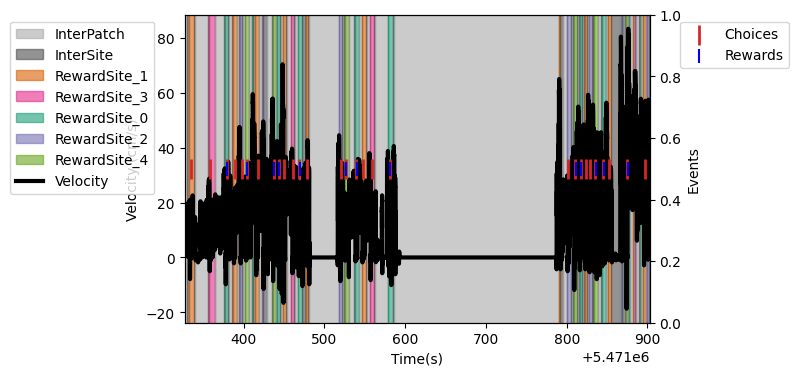

In [17]:
from ssvr.visualization import a_lot_of_style, plot_ethogram

plot_ethogram(session_datasets[0], show_plot=True)

In [23]:
session.trials
for site_type in session.trials["patch_index"].unique():
    site_trials = session.trials[session.trials["patch_index"] == site_type]
    print(f"Site type {site_type}: {len(site_trials)} trials")
    p_stop = site_trials["is_choice"].mean()
    print(f"  Probability of stopping: {p_stop:.2f}")
    p_reward = site_trials["is_rewarded"].mean()
    print(f"  Probability of reward: {p_reward:.2f}")

Site type 1: 11 trials
  Probability of stopping: 0.82
  Probability of reward: 0.00
Site type 3: 4 trials
  Probability of stopping: 0.75
  Probability of reward: 0.00
Site type 0: 10 trials
  Probability of stopping: 0.70
  Probability of reward: 0.88
Site type 2: 6 trials
  Probability of stopping: 0.67
  Probability of reward: 0.00
Site type 4: 6 trials
  Probability of stopping: 1.00
  Probability of reward: 1.00
